## Import

In [323]:
import sys
print(sys.executable)

d:\Python3119\python.exe


In [324]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

## Data

In [325]:
sample = pd.read_csv("dataset/processed_data/agresja_2.csv")
sample.head()

,Unnamed: 0,id,x_px,y_px,z_px,visibility,x,y,z
0,8,8,82,9,801,0.999930,0.291815,0.007550,0.395360
1,7,7,170,8,1023,0.999673,0.604982,0.006711,0.504936
2,20,20,136,150,67,0.955415,0.483986,0.125839,0.033070
3,16,16,106,205,112,0.980326,0.377224,0.171980,0.055281
4,14,14,0,338,363,0.973594,0.000000,0.283557,0.179171


In [326]:
sample.info()
sample.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  19 non-null     int64  
 1   id          19 non-null     int64  
 2   x_px        19 non-null     int64  
 3   y_px        19 non-null     int64  
 4   z_px        19 non-null     int64  
 5   visibility  19 non-null     float64
 6   x           19 non-null     float64
 7   y           19 non-null     float64
 8   z           19 non-null     float64
dtypes: float64(4), int64(5)
memory usage: 1.5 KB


Unnamed: 0    0
id            0
x_px          0
y_px          0
z_px          0
visibility    0
x             0
y             0
z             0
dtype: int64

In [327]:
BONES = [
    (11, 13),  # LEFT_SHOULDER -> LEFT_ELBOW
    (13, 15),  # LEFT_ELBOW -> LEFT_WRIST
    (12, 14),  # RIGHT_SHOULDER -> RIGHT_ELBOW
    (14, 16),  # RIGHT_ELBOW -> RIGHT_WRIST
    (23, 25),  # LEFT_HIP -> LEFT_KNEE
    (25, 27),  # LEFT_KNEE -> LEFT_ANKLE
    (24, 26),  # RIGHT_HIP -> RIGHT_KNEE
    (26, 28),  # RIGHT_KNEE -> RIGHT_ANKLE
]

def skeleton_to_feature_vector(df_skeleton):
    if df_skeleton is None:
        return None

    hip_center_x = (df_skeleton.loc[23, "x"] + df_skeleton.loc[24, "x"]) / 2
    hip_center_y = (df_skeleton.loc[23, "y"] + df_skeleton.loc[24, "y"]) / 2

    shoulder_width = df_skeleton.loc[12, "x"] - df_skeleton.loc[11, "x"]
    if shoulder_width == 0:
        shoulder_width = 1e-6

    norm_points = {}
    for idx, row in df_skeleton.iterrows():
        norm_x = (row["x"] - hip_center_x) / shoulder_width
        norm_y = (row["y"] - hip_center_y) / shoulder_width
        norm_points[idx] = (norm_x, norm_y)

    features = []
    for start, end in BONES:
        start_pt = np.array(norm_points[start])
        end_pt = np.array(norm_points[end])
        vec = end_pt - start_pt
        features.extend(vec.tolist())

    return np.array(features)

In [328]:
sample.set_index("id")

,Unnamed: 0,x_px,y_px,z_px,visibility,x,y,z
id,,,,,,,,
8,8,82,9,801,0.999930,0.291815,0.007550,0.395360
7,7,170,8,1023,0.999673,0.604982,0.006711,0.504936
20,20,136,150,67,0.955415,0.483986,0.125839,0.033070
16,16,106,205,112,0.980326,0.377224,0.171980,0.055281
14,14,0,338,363,0.973594,0.000000,0.283557,0.179171
12,12,24,141,749,0.999906,0.085409,0.118289,0.369694
11,11,182,141,1336,0.998773,0.647687,0.118289,0.659427
13,13,281,278,995,0.888405,1.000000,0.233221,0.491115
15,15,229,141,443,0.939617,0.814947,0.118289,0.218657


In [329]:
def csv_to_features(path):
    df = pd.read_csv(path)
    df = df.set_index("id")
    #return skeleton_to_feature_vector(df)

    feature_cols = ["x", "y", "z", "visibility"]
    df = df[feature_cols]

    return df
    #.to_numpy().flatten()

In [330]:
important_points = [8, 7, 20, 16, 14, 12, 11, 13, 15, 19, 24, 23, 26, 25, 26, 28, 32 ,27, 31]

LEFT_RIGHT_PAIRS = [
    (7, 8), 
    (11, 12), (13, 14), (15, 16),
    (19, 20),
    (23, 24), (25, 26), (27, 28),
    (31, 32)
]

def flip_pose(df):
    df = df.copy()

    df["x"] = -df["x"]

    for left, right in LEFT_RIGHT_PAIRS:    
        if left in df.index and right in df.index:
            df.loc[[left, right]] = df.loc[[right, left]].values

    return df

In [331]:
def scale_pose(df, scale_range=(0.9, 1.1)):
    df = df.copy()
    scale = np.random.uniform(*scale_range)
    df[["x", "y", "z"]] *= scale
    return df

In [332]:
def rotate_y(df, angle_range=(-15, 15)):
    df = df.copy()
    angle = np.deg2rad(np.random.uniform(*angle_range))

    cos_a, sin_a = np.cos(angle), np.sin(angle)

    x = df["x"].values
    z = df["z"].values

    df["x"] = cos_a * x - sin_a * z
    df["z"] = sin_a * x + cos_a * z

    return df

In [334]:
def add_noise(df, sigma=0.01):
    df = df.copy()
    noise = np.random.normal(0, sigma, size=(len(df), 3))
    df[["x", "y", "z"]] += noise
    return df

In [336]:
def augment_pose(df):
    if np.random.rand() < 0.5:
        df = rotate_y(df)
    if np.random.rand() < 0.5:
        df = scale_pose(df)
    if np.random.rand() < 0.3:
        df = add_noise(df)
    return df

In [337]:
def label_from_filename(filename):
    name = filename.lower()
    if "agresja" in name:
        return "Aggression"
    if "neutralnosc" in name:
        return "Neutrality"
    if "lek" in name:
        return "Fear"
    return "Uncertain"

In [338]:
csv_to_features("dataset/processed_data/agresja_2.csv")

,x,y,z,visibility
id,,,,
8,0.291815,0.007550,0.395360,0.999930
7,0.604982,0.006711,0.504936,0.999673
20,0.483986,0.125839,0.033070,0.955415
16,0.377224,0.171980,0.055281,0.980326
14,0.000000,0.283557,0.179171,0.973594
12,0.085409,0.118289,0.369694,0.999906
11,0.647687,0.118289,0.659427,0.998773
13,1.000000,0.233221,0.491115,0.888405
15,0.814947,0.118289,0.218657,0.939617


In [339]:
X = []
y = []

for file in Path("dataset/processed_data").glob("*.csv"):
    df = csv_to_features(file)
    #print(df)

    X.append(df.to_numpy().flatten())
    y.append(label_from_filename(file.name))

    flipped_df = flip_pose(df)
    X.append(flipped_df.to_numpy().flatten())
    y.append(label_from_filename(file.name))

    aug_df = augment_pose(df)
    X.append(aug_df.to_numpy().flatten())
    y.append(label_from_filename(file.name))

X = np.array(X)
y = np.array(y)

In [340]:
pd.Series(y).value_counts()

Neutrality    135
Fear          108
Aggression     87
Name: count, dtype: int64

## Preparing Data

In [341]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42
)

In [342]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Models

### Random Forest

In [343]:
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42
)
rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

### KNN

In [344]:
knn = KNeighborsClassifier(
    n_neighbors=7,
    weights="distance"
)
knn.fit(X_train, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",7
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'distance'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


### Decision Tree

In [345]:
dt = DecisionTreeClassifier(
    max_depth=15,
    class_weight="balanced",
    random_state=42
)
dt.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",15
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current n

### Basic Neural Network

In [346]:
mlp = MLPClassifier(
    hidden_layer_sizes=(256,128),
    max_iter=500,
    random_state=42,
    early_stopping=True
)
mlp.fit(X_train, y_train)

,"hidden_layer_sizes hidden_layer_sizes: array-like of shape(n_layers - 2,), default=(100,)The ith element represents the number of neurons in the ithhidden layer.","(256, ...)"
,"activation activation: {'identity', 'logistic', 'tanh', 'relu'}, default='relu'Activation function for the hidden layer.- 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x- 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).- 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).- 'relu', the rectified linear unit function, returns f(x) = max(0, x)",'relu'
,"solver solver: {'lbfgs', 'sgd', 'adam'}, default='adam'The solver for weight optimization.- 'lbfgs' is an optimizer in the family of quasi-Newton methods.- 'sgd' refers to stochastic gradient descent.- 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy BaFor a comparison between Adam optimizer and SGD, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_training_curves.py`.Note: The default solver 'adam' works pretty well on relativelylarge datasets (with thousands of training samples or more) in terms ofboth training time and validation score.For small datasets, however, 'lbfgs' can converge faster and performbetter.",'adam'
,"alpha alpha: float, default=0.0001Strength of the L2 regularization term. The L2 regularization termis divided by the sample size when added to the loss.For an example usage and visualization of varying regularization, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_alpha.py`.",0.0001
,"batch_size batch_size: int, default='auto'Size of minibatches for stochastic optimizers.If the solver is 'lbfgs', the classifier will not use minibatch.When set to ""auto"", `batch_size=min(200, n_samples)`.",'auto'
,"learning_rate learning_rate: {'constant', 'invscaling', 'adaptive'}, default='constant'Learning rate schedule for weight updates.- 'constant' is a constant learning rate given by 'learning_rate_init'.- 'invscaling' gradually decreases the learning rate at each time step 't' using an inverse scaling exponent of 'power_t'. effective_learning_rate = learning_rate_init / pow(t, power_t)- 'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if 'early_stopping' is on, the current learning rate is divided by 5.Only used when ``solver='sgd'``.",'constant'
,"learning_rate_init learning_rate_init: float, default=0.001The initial learning rate used. It controls the step-sizein updating the weights. Only used when solver='sgd' or 'adam'.",0.001
,"power_t power_t: float, default=0.5The exponent for inverse scaling learning rate.It is used in updating effective learning rate when the learning_rateis set to 'invscaling'. Only used when solver='sgd'.",0.5
,"max_iter max_iter: int, default=200Maximum number of iterations. The solver iterates until convergence(determined by 'tol') or this number of iterations. For stochasticsolvers ('sgd', 'adam'), note that this determines the number of epochs(how many times each data point will be used), not the number ofgradient steps.",500
,"shuffle shuffle: bool, default=TrueWhether to shuffle samples in each iteration. Only used whensolver='sgd' or 'adam'.",True
,"random_state random_state: int, RandomState instance, default=NoneDetermines random number generation for weights and biasinitialization, train-test split if early stopping is used, and batchsampling when solver='sgd' or 'adam'.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42


## Evaluation

In [347]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

models = {
    "RandomForest": rf,
    "KNN": knn,
    "DecisionTree": dt,
    "MLP": mlp
}

for name, model in models.items(): 
    print(f"\n{name}") 
    y_pred = model.predict(X_test) 
    print(classification_report(y_test, y_pred, target_names=le.classes_))


RandomForest
              precision    recall  f1-score   support

  Aggression       0.94      0.84      0.89        19
        Fear       0.96      1.00      0.98        22
  Neutrality       0.92      0.96      0.94        25

    accuracy                           0.94        66
   macro avg       0.94      0.93      0.94        66
weighted avg       0.94      0.94      0.94        66


KNN
              precision    recall  f1-score   support

  Aggression       0.86      0.63      0.73        19
        Fear       0.76      0.86      0.81        22
  Neutrality       0.81      0.88      0.85        25

    accuracy                           0.80        66
   macro avg       0.81      0.79      0.79        66
weighted avg       0.81      0.80      0.80        66


DecisionTree
              precision    recall  f1-score   support

  Aggression       0.93      0.68      0.79        19
        Fear       0.79      1.00      0.88        22
  Neutrality       0.88      0.84      0.8

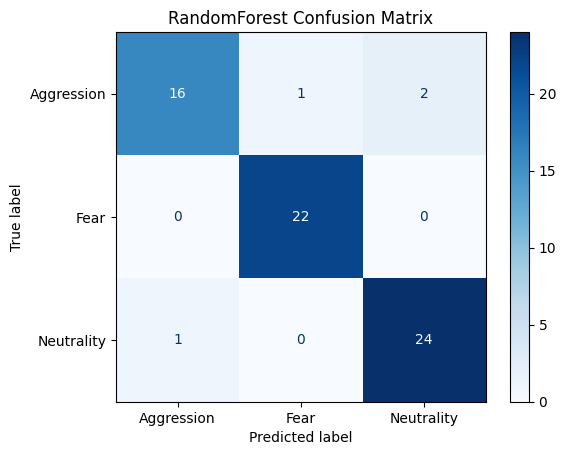

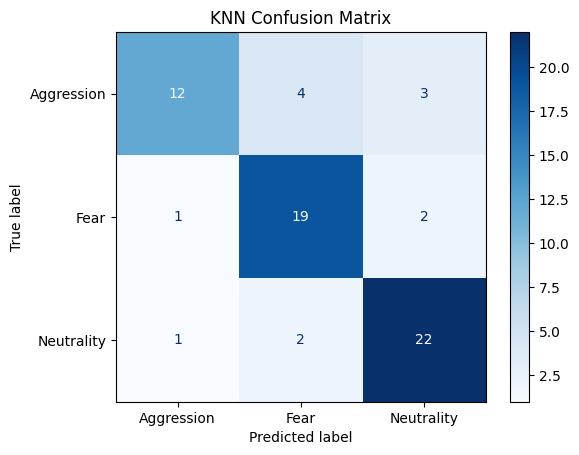

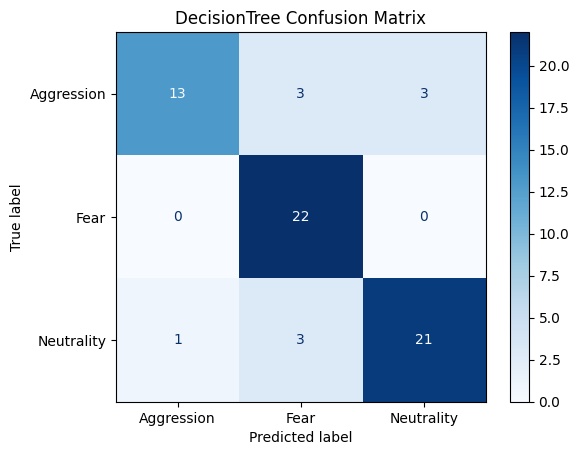

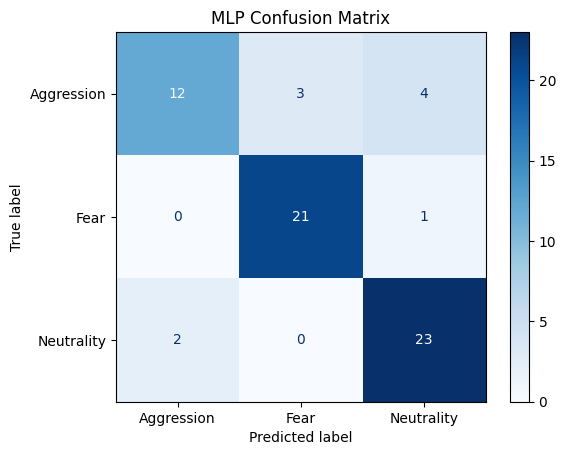

In [348]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=le.classes_
    )

    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

In [349]:
def predict_with_confidence(model, X_sample, threshold=0.4):
    probs = model.predict_proba(X_sample.reshape(1, -1))[0]
    result = dict(zip(le.classes_, probs))

    best_label = max(result, key=result.get)
    best_prob = result[best_label]

    if best_prob < threshold:
        return "Niejednoznaczne", result

    return best_label, result

In [350]:
label, probs = predict_with_confidence(rf, X_test[3])

label, {k: round(v, 2) for k, v in probs.items()}

(np.str_('Aggression'),
 {np.str_('Aggression'): np.float64(0.42),
  np.str_('Fear'): np.float64(0.32),
  np.str_('Neutrality'): np.float64(0.26)})

In [351]:
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"{name}: {scores.mean():.3f}")

RandomForest: 0.856
KNN: 0.772
DecisionTree: 0.738
MLP: 0.671
